# 1. Baseline QoE Inference with Induced NaN Values

In this notebook, we train and test a classification model to predict Netflix video resolution using network traffic. The model is trained on the netflix_resolution_nan_window pcap which had randomly induced NaN values in the TCP window size field. NaN values are simply ignored in this ML pipeline to provide a baseline for model performance, which we later compare to a model trained on a pcap where these values are imputed. 

## Import NaN-Induced Pcap

In [1]:
## Import Netflix Pcap with induced NaN values

from scapy.all import rdpcap, IP, IPv6, TCP, UDP, DNS
import pandas as pd

pkts = rdpcap("./data/netflix_resolution_nan_window.pcap")
rows = []

for p in pkts:
    is_dns = DNS in p
    proto = "DNS" if is_dns else ("TCP" if TCP in p else ("UDP" if UDP in p else p.name))
    txid = p[DNS].id if is_dns else None
    
    # Get IP addresses - check both IPv4 and IPv6
    src_ip = None
    dst_ip = None
    
    if IPv6 in p:
        src_ip = p[IPv6].src
        dst_ip = p[IPv6].dst
    elif IP in p:
        src_ip = p[IP].src
        dst_ip = p[IP].dst
    
    rows.append({
        "timestamp": float(getattr(p, "time", None)),
        "length": len(p),
        "src_ip": src_ip,
        "dst_ip": dst_ip,
        "protocol": proto,
        "src_port": p[TCP].sport if TCP in p else (p[UDP].sport if UDP in p else None),
        "dst_port": p[TCP].dport if TCP in p else (p[UDP].dport if UDP in p else None),
        "txid": txid,
        "info": str(p.summary())
    })

nflx_pcap = pd.DataFrame(rows)

nflx_pcap.head()

,timestamp,length,src_ip,dst_ip,protocol,src_port,dst_port,txid,info
0,1.765427e+09,1081,10.0.0.154,224.0.0.251,DNS,5353.0,5353.0,0.0,"Ether / IP / UDP / DNS Ans ""[b'container_id={1..."
1,1.765427e+09,1101,fe80::c2e5:daff:fe92:5423,ff02::fb,DNS,5353.0,5353.0,0.0,"Ether / IPv6 / UDP / DNS Ans ""[b'container_id=..."
2,1.765427e+09,86,2601:240:c484:b660:71e8:12b4:aa8c:c805,2a00:86c0:108:108:2::69,TCP,64364.0,443.0,NaN,Ether / IPv6 / TCP 2601:240:c484:b660:71e8:12b...
3,1.765427e+09,86,2601:240:c484:b660:71e8:12b4:aa8c:c805,2a00:86c0:108:108:2::69,TCP,64370.0,443.0,NaN,Ether / IPv6 / TCP 2601:240:c484:b660:71e8:12b...
4,1.765427e+09,173,10.0.0.246,224.0.0.251,DNS,5353.0,5353.0,0.0,"Ether / IP / UDP / DNS Qry ""b'_companion-link...."


## Get Netflix IPs Using SNI

In [8]:
import subprocess

NETFLIX_KEYWORDS = [
    "netflix", "nflxvideo", "nflxso",
    "nflxext", "nflximg", "nflx"
]

def is_netflix_hostname(h):
    if not h:
        return False
    h = h.lower()
    return any(k in h for k in NETFLIX_KEYWORDS)


def extract_netflix_ips_tshark(pcap_file):

    # Extract SNI + IP from TLS Client Hello
    cmd = [
        "tshark",
        "-r", pcap_file,
        "-Y", "tls.handshake.extensions_server_name",
        "-T", "fields",
        "-e", "tls.handshake.extensions_server_name",
        "-e", "ip.src",
        "-e", "ip.dst",
        "-e", "ipv6.src",
        "-e", "ipv6.dst",
    ]

    result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    lines = result.stdout.splitlines()

    netflix_ips = set()

    for line in lines:
        fields = line.split("\t")

        # columns: SNI, ip.src, ip.dst, ipv6.src, ipv6.dst
        sni = fields[0] if len(fields) > 0 else ""
        ip4_src = fields[1] if len(fields) > 1 else ""
        ip4_dst = fields[2] if len(fields) > 2 else ""
        ip6_src = fields[3] if len(fields) > 3 else ""
        ip6_dst = fields[4] if len(fields) > 4 else ""

        if is_netflix_hostname(sni):

            # add all addresses
            for ip in (ip4_src, ip4_dst, ip6_src, ip6_dst):
                if ip:
                    netflix_ips.add(ip)

    return netflix_ips


netflix_ips = extract_netflix_ips_tshark("./data/netflix_resolution.pcap")

print("\n==============================")
print(" Netflix IP Addresses (SNI matched)")
print("==============================")

for ip in sorted(netflix_ips):
    print(ip)

print("\nTotal unique:", len(netflix_ips))



 Netflix IP Addresses (SNI matched)
2601:240:c484:b660:71e8:12b4:aa8c:c805
2a00:86c0:1034:1034::144
2a00:86c0:1034:1034::147
2a00:86c0:1034:1034::166
2a00:86c0:1035:1035::155
2a00:86c0:1035:1035::156
2a00:86c0:1035:1035::202
2a00:86c0:109:109:2::13
2a00:86c0:109:109:2::67
2a00:86c0:109:109:2::72
2a00:86c0:109:109::12b
2a00:86c0:109:109::251
2a03:5640:f502:80::81a0:1099
2a03:5640:f502:80::8834:17e
2a03:5640:f502:80::ee21:17e
2a03:5640:f502:82::d95:1099

Total unique: 16


## Filter for Netflix Packets

In [ ]:
nflx_pkts = nflx_pcap[
    nflx_pcap['src_ip'].isin(netflix_ips) | 
    nflx_pcap['dst_ip'].isin(netflix_ips)
]

print(f"Total Netflix-related packets: {len(nflx_pkts)}")
print(f"Percentage of traffic: {len(nflx_pkts)/len(nflx_pcap)*100:.2f}%")

nflx_pkts.head()

Total Netflix-related packets: 78944
Percentage of traffic: 93.49%


,timestamp,length,src_ip,dst_ip,protocol,src_port,dst_port,txid,info
2,1.765427e+09,86,2601:240:c484:b660:71e8:12b4:aa8c:c805,2a00:86c0:108:108:2::69,TCP,64364.0,443.0,NaN,Ether / IPv6 / TCP 2601:240:c484:b660:71e8:12b...
3,1.765427e+09,86,2601:240:c484:b660:71e8:12b4:aa8c:c805,2a00:86c0:108:108:2::69,TCP,64370.0,443.0,NaN,Ether / IPv6 / TCP 2601:240:c484:b660:71e8:12b...
8,1.765427e+09,330,2601:240:c484:b660:71e8:12b4:aa8c:c805,2a03:5640:f502:82::8834:17e,TCP,63216.0,443.0,NaN,Ether / IPv6 / TCP 2601:240:c484:b660:71e8:12b...
9,1.765427e+09,125,2601:240:c484:b660:71e8:12b4:aa8c:c805,2a03:5640:f502:82::8834:17e,TCP,63216.0,443.0,NaN,Ether / IPv6 / TCP 2601:240:c484:b660:71e8:12b...
10,1.765427e+09,86,2a03:5640:f502:82::8834:17e,2601:240:c484:b660:71e8:12b4:aa8c:c805,TCP,443.0,63216.0,NaN,Ether / IPv6 / TCP 2a03:5640:f502:82::8834:17e...


## Create Flows and Features

In [ ]:
import numpy as np

# Filter for tcp, udp traffic only
df = nflx_pkts.copy()
df = df[df["protocol"].fillna("").str.lower().isin(["tcp", "udp"])].reset_index(drop=True)

# Ensure timestamp and length numeric
df["timestamp"] = df["timestamp"].astype(float)
df["length"] = df["length"].astype(int)

# Compute 1-second time window (align to multiples of 1)
df["time_window"] = (np.floor(df["timestamp"] / 1) * 1).astype(int)

# Compute inter-arrival time for each packet
df['iat'] = df.groupby("time_window")["timestamp"].diff()


# Aggregate per time window
nflx_flows = df.groupby("time_window").agg(
    packet_count=("length", "size"),
    total_bytes=("length", "sum"),
    mean_pkt_size=("length", "mean"),
    max_pkt_size=("length", "max"),
    min_pkt_size=("length", "min"),
    unique_dst_ips=("dst_ip", "nunique"),
    pkt_size_std=('length', 'std'),
    pkt_size_median=('length', 'median'),
    pkt_size_sum=('length', 'sum'),
    pkt_size_25th=('length', lambda x: x.quantile(0.25)),
    pkt_size_75th=('length', lambda x: x.quantile(0.75)),
    
    # Inter-arrival time statistics
    iat_min=('iat', 'min'),
    iat_max=('iat', 'max'),
    iat_mean=('iat', 'mean'),
    iat_std=('iat', 'std'),
    iat_median=('iat', 'median'),
    iat_25th=('iat', lambda x: x.quantile(0.25)),
    iat_75th=('iat', lambda x: x.quantile(0.75)),
).reset_index()


# Show result
print("Per-window summary rows:", len(nflx_flows))
print("\nFlow features (first 10 windows):")
nflx_flows.head(10)

Per-window summary rows: 483

Flow features (first 10 windows):


,time_window,packet_count,total_bytes,mean_pkt_size,max_pkt_size,min_pkt_size,unique_dst_ips,pkt_size_std,pkt_size_median,pkt_size_sum,pkt_size_25th,pkt_size_75th,iat_min,iat_max,iat_mean,iat_std,iat_median,iat_25th,iat_75th
0,1765426684,2,172,86.000000,86,86,1,0.000000,86.0,172,86.00,86.0,0.107925,0.107925,0.107925,NaN,0.107925,1.079249e-01,0.107925
1,1765426685,26,14669,564.192308,1514,86,3,652.709247,123.0,14669,86.00,1514.0,0.000000,0.367278,0.030633,0.075213,0.000200,1.907349e-06,0.027713
2,1765426686,283,326219,1152.717314,1514,86,4,599.390824,1514.0,326219,591.00,1514.0,0.000000,0.356711,0.002775,0.022360,0.000002,9.536743e-07,0.000025
3,1765426687,185,166840,901.837838,1514,86,6,659.024498,1474.0,166840,86.00,1514.0,0.000000,0.130654,0.004982,0.016678,0.000002,9.536743e-07,0.000193
4,1765426688,311,240297,772.659164,1514,86,13,634.467559,554.0,240297,93.50,1514.0,0.000000,0.174440,0.002283,0.011622,0.000003,9.536743e-07,0.000126
5,1765426689,302,260711,863.281457,1514,86,7,667.078211,1009.5,260711,86.00,1514.0,0.000000,0.114242,0.002259,0.010475,0.000003,9.536743e-07,0.000107
6,1765426690,404,467969,1158.339109,1514,86,8,589.221399,1514.0,467969,909.00,1514.0,0.000000,0.197696,0.002333,0.013390,0.000001,9.536743e-07,0.000036
7,1765426691,174,201364,1157.264368,1514,86,5,584.097000,1514.0,201364,850.75,1514.0,0.000000,0.136238,0.005502,0.020677,0.000002,9.536743e-07,0.000087
8,1765426692,262,278764,1063.984733,1514,86,8,626.074218,1514.0,278764,166.25,1514.0,0.000000,0.120968,0.003170,0.011303,0.000002,9.536743e-07,0.000104
9,1765426693,568,542731,955.512324,1514,74,16,667.592185,1514.0,542731,86.00,1514.0,0.000000,0.170079,0.001692,0.008412,0.000002,9.536743e-07,0.000178


## Get Resolution Labels

In [ ]:
labels_df = pd.read_csv("./data/netflix_resolution_labels.csv")

# Extract the specific columns and rename
labels_df = labels_df[['timestamp_ms', 'videoHeight']].copy()
labels_df = labels_df.rename(columns={'videoHeight': 'resolution'})

print(f"Labels shape: {labels_df.shape}")
print(f"\nColumns: {labels_df.columns.tolist()}")
print(f"\nFirst few rows:")
labels_df.head()

Labels shape: (467, 2)

Columns: ['timestamp_ms', 'resolution']

First few rows:


,timestamp_ms,resolution
0,1765426713257,270
1,1765426714260,270
2,1765426715258,270
3,1765426716258,270
4,1765426717259,270


## Join Labels and Features

In [6]:
# Convert timestamp_ms to seconds for matching with nflx_pkts
labels_df['timestamp_sec'] = (labels_df['timestamp_ms'] / 1000).astype(float)

# Create 1-second time window for labels (same logic as nflx_pkts)
labels_df['time_window'] = (np.floor(labels_df['timestamp_sec'] / 1) * 1).astype(int)

# Join labels onto nflx_flows based on time_window
nflx_flows_joined = nflx_flows.merge(
    labels_df[['time_window', 'resolution']], 
    on='time_window', 
    how='inner'
)

print(f"nflx_flows shape after join: {nflx_flows_joined.shape}")
print(f"\nFlows with resolution labels: {nflx_flows_joined['resolution'].notna().sum()}")
print(f"Flows without labels: {nflx_flows_joined['resolution'].isna().sum()}")
print(f"\nResolution distribution:")
print(nflx_flows_joined['resolution'].value_counts(dropna=False))

print(f"\nSample joined data:")
nflx_flows_joined.head(500)

nflx_flows shape after join: (454, 20)

Flows with resolution labels: 454
Flows without labels: 0

Resolution distribution:
resolution
720     227
1080    150
270      39
540      22
342      11
432       5
Name: count, dtype: int64

Sample joined data:


,time_window,packet_count,total_bytes,mean_pkt_size,max_pkt_size,min_pkt_size,unique_dst_ips,pkt_size_std,pkt_size_median,pkt_size_sum,pkt_size_25th,pkt_size_75th,iat_min,iat_max,iat_mean,iat_std,iat_median,iat_25th,iat_75th,resolution
0,1765426713,2,172,86.000000,86,86,2,0.000000,86.0,172,86.0,86.0,2.337110e-01,0.233711,0.233711,NaN,2.337110e-01,2.337110e-01,0.233711,270
1,1765426714,332,433099,1304.515060,1514,74,4,490.410929,1514.0,433099,1514.0,1514.0,0.000000e+00,0.070394,0.000962,0.005492,1.192093e-06,9.536743e-07,0.000002,270
2,1765426715,179,224979,1256.865922,1514,86,3,541.819929,1514.0,224979,1514.0,1514.0,9.536743e-07,0.037378,0.000973,0.004055,1.907349e-06,1.192093e-06,0.000069,270
3,1765426716,230,246379,1071.213043,1514,86,8,628.002700,1474.0,246379,106.0,1514.0,0.000000e+00,0.078778,0.003354,0.010957,2.145767e-06,9.536743e-07,0.000124,270
4,1765426717,232,279026,1202.698276,1514,86,4,577.974456,1514.0,279026,1514.0,1514.0,0.000000e+00,0.190133,0.003364,0.016925,1.907349e-06,9.536743e-07,0.000011,270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,1765427167,199,238760,1199.798995,1514,74,4,588.623621,1514.0,238760,1514.0,1514.0,0.000000e+00,0.163784,0.004651,0.021543,1.907349e-06,9.536743e-07,0.000069,1080
450,1765427168,301,386061,1282.594684,1514,86,3,523.739867,1514.0,386061,1514.0,1514.0,0.000000e+00,0.169562,0.003313,0.016815,9.536743e-07,9.536743e-07,0.000024,1080
451,1765427169,161,200066,1242.645963,1514,86,3,559.238929,1514.0,200066,1514.0,1514.0,0.000000e+00,0.460064,0.005182,0.038742,1.072884e-06,9.536743e-07,0.000003,1080
452,1765427170,75,83577,1114.360000,1514,86,3,645.166554,1514.0,83577,88.0,1514.0,0.000000e+00,0.431876,0.007838,0.050362,2.145767e-06,1.907349e-06,0.000193,1080


## Train-Test-Split Random Forest Classifier to Predict Resolutiom

RANDOM FOREST - RESOLUTION PREDICTION

Grouped class distribution:
resolution
full_hd    120
hd         181
low         44
medium      18
Name: count, dtype: int64

Model Performance:
   Accuracy: 0.6593

   Classification Report:
              precision    recall  f1-score   support

     full_hd       0.70      0.63      0.67        30
          hd       0.66      0.85      0.74        46
         low       0.50      0.18      0.27        11
      medium       0.00      0.00      0.00         4

    accuracy                           0.66        91
   macro avg       0.47      0.42      0.42        91
weighted avg       0.63      0.66      0.63        91



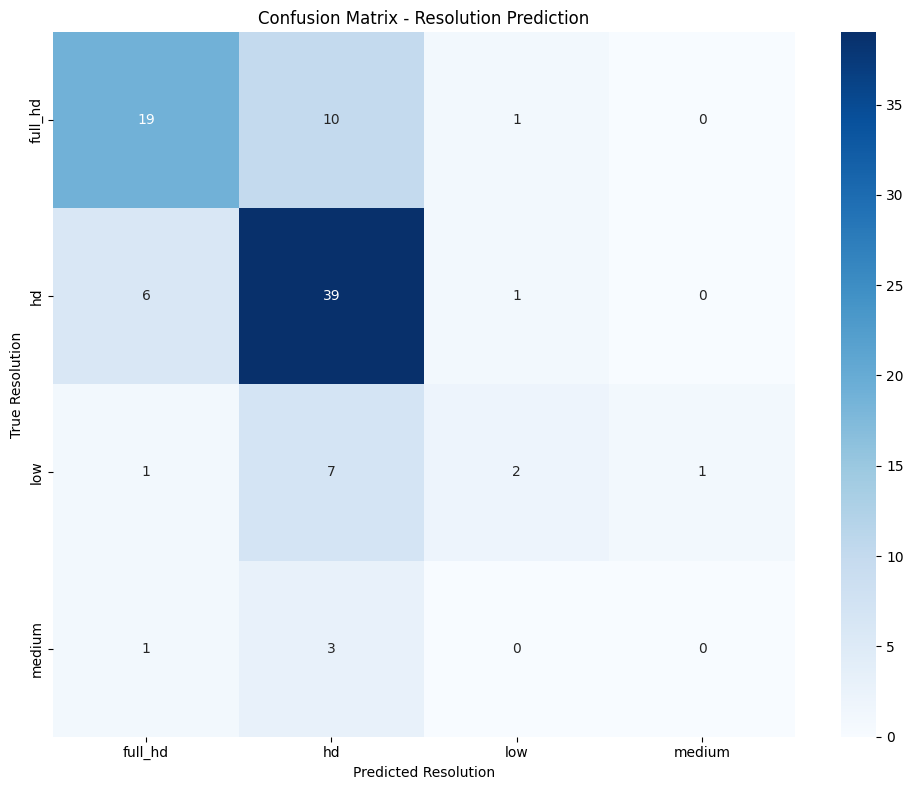

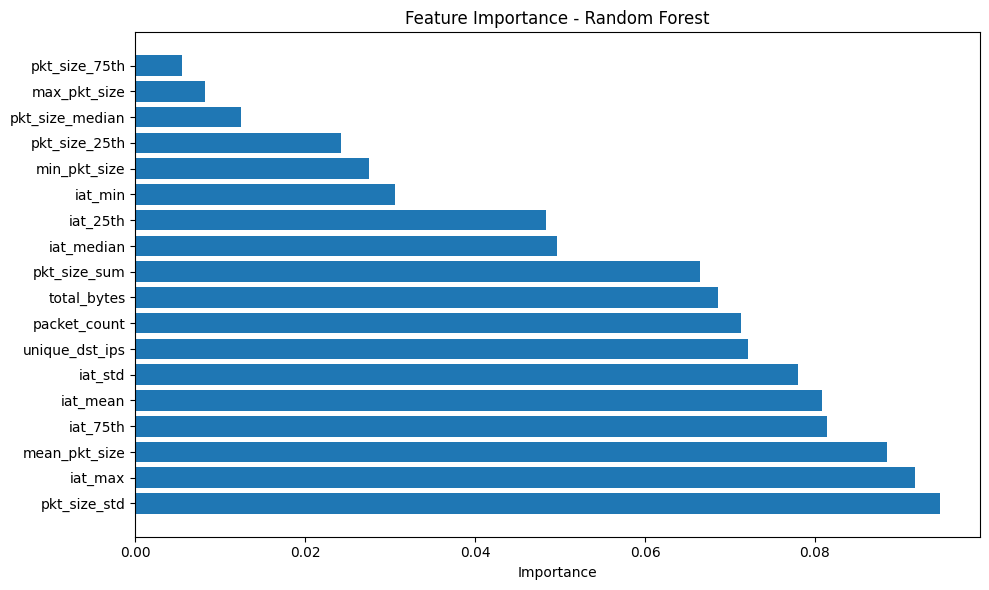

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("RANDOM FOREST - RESOLUTION PREDICTION")
print("="*60)

feature_cols = [
    # Basic packet statistics
    'packet_count',
    'total_bytes',
    'mean_pkt_size',
    'max_pkt_size',
    'min_pkt_size',
    'pkt_size_std',
    'pkt_size_median',
    'pkt_size_sum',
    'pkt_size_25th',
    'pkt_size_75th',
    
    # Inter-arrival time statistics
    'iat_min',
    'iat_max',
    'iat_mean',
    'iat_std',
    'iat_median',
    'iat_25th',
    'iat_75th',
    
    # Network diversity
    'unique_dst_ips'
]

X = nflx_flows_joined[feature_cols]
y = nflx_flows_joined['resolution']

# Handle any NaN values in features
X = X.fillna(0)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest
# ==============================
# Group resolutions into broader categories to improve model performance
# Not enough samples for low resolutions to train effectively
# =============================
def group_resolutions(res):
    """Group resolutions into broader categories"""
    if res <= 432:
        return 'low'  # 270, 342, 432
    elif res == 540:
        return 'medium'  # 540
    elif res == 720:
        return 'hd'  # 720
    else:
        return 'full_hd'  # 1080+

y_train_grouped = y_train.apply(group_resolutions)
y_test_grouped = y_test.apply(group_resolutions)

print("\nGrouped class distribution:")
print(y_train_grouped.value_counts().sort_index())

rf_grouped = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=41,
    n_jobs=-1
)

rf_grouped.fit(X_train, y_train_grouped)
y_pred_grouped = rf_grouped.predict(X_test)


# Evaluate
print(f"\nModel Performance:")
print(f"   Accuracy: {accuracy_score(y_test_grouped, y_pred_grouped):.4f}")

print(f"\n   Classification Report:")
print(classification_report(y_test_grouped, y_pred_grouped))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_grouped.feature_importances_
}).sort_values('importance', ascending=False)

# Confusion Matrix
cm = confusion_matrix(y_test_grouped, y_pred_grouped)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y_test_grouped.unique()), 
            yticklabels=sorted(y_test_grouped.unique()))
plt.title('Confusion Matrix - Resolution Prediction')
plt.ylabel('True Resolution')
plt.xlabel('Predicted Resolution')
plt.tight_layout()
plt.show()

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()